In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [6]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/brca.TIGIT.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE,joined.TIGIT_label
0,71.806464,129.127076,1.158576,122.432688,194.239152,0.369681,0.664784,0.630319,6722.417551,6665.889385,...,162597,4593,24879,38851,43444,12789,27081,26708,39497,1
1,82.396624,168.316672,2.677280,145.747888,228.144512,0.361160,0.737763,0.638840,6594.895183,6647.129359,...,65822,3040,14794,24867,27907,1328,3955,6120,7448,1
2,26.877520,53.040932,3.571664,44.355952,71.233472,0.377316,0.744607,0.622684,5833.355998,6531.812070,...,45076,1546,7789,12735,14281,729,2571,4174,4903,1
3,43.128576,111.292004,0.742096,98.095856,141.224432,0.305390,0.788051,0.694610,7160.616676,7223.818109,...,44382,1897,5594,9934,11831,1837,2488,1965,3802,1
4,0.685216,2.596956,1.605504,8.142384,8.827600,0.077622,0.294186,0.922378,4479.384456,4093.277627,...,17273,452,1604,4450,4902,181,289,527,708,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,9.903376,11.445204,0.085904,11.510544,21.413920,0.462474,0.534475,0.537526,5228.674659,6463.852141,...,7137,1701,1250,2016,3717,270,322,486,756,0
772,29.783936,47.477228,0.007680,23.035728,52.819664,0.563880,0.898855,0.436120,6143.226420,7334.381654,...,13332,1061,2049,1739,2800,3023,3154,735,3758,1
773,49.370816,87.116700,0.016976,62.198960,111.569776,0.442511,0.780827,0.557489,5869.237691,6358.235055,...,46429,8881,6618,5780,14661,3364,3586,1754,5118,1
774,11.947152,20.351728,1.422320,12.491184,24.438336,0.488869,0.832779,0.511131,5604.175185,5747.899181,...,18026,1739,2683,1693,3432,1439,1578,372,1811,0


In [10]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
# X_normalized

In [11]:
y = df.iloc[:,607]
print(np.sum(y))

379


In [12]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/BRCA.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
# clusters


Number of Clusters: 20


## Define Nested CV Parameters

In [13]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

258 258
259 259
259 259
0.4883720930232558
0.49034749034749037
0.4864864864864865


### Outer Loop 1

In [14]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(517, 607) (517,)
(259, 607) (259,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7067676940151968, 0.7017556561085974, 0.7152650900708615, 0.7294969691795441, 0.7390924044508951, 0.752885170323572, 0.7629225077549162, 0.7650974700475255, 0.7436776231537608, 0.7749128888129999, 0.7430524488460115, 0.7475912234269616, 0.7531641196391474, 0.7716478556589543, 0.735385810637753, 0.7606421924357551, 0.7699479211132929, 0.7342218617490539, 0.7673090298528701, 0.7632807991120976, 0.783284954039671, 0.7842074048777712, 0.7646014969122626, 0.7175333959418311, 0.7794906514129599, 0.7787312103360937, 0.7373422123566409, 0.712156862745098, 0.5, 0.5]


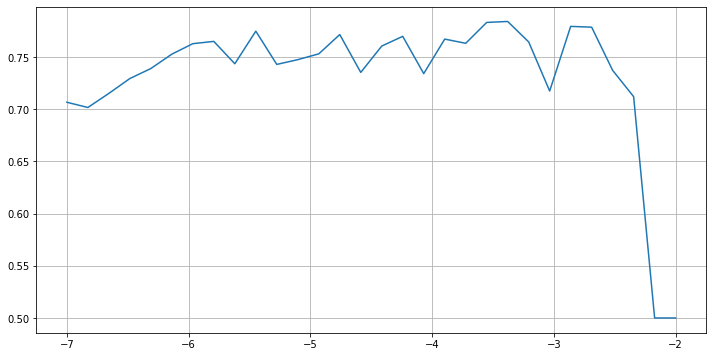

0.03407094383662396 -3.3793103448275854


In [12]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

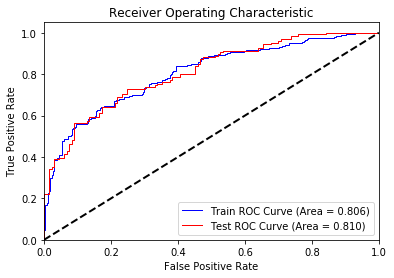

In [16]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

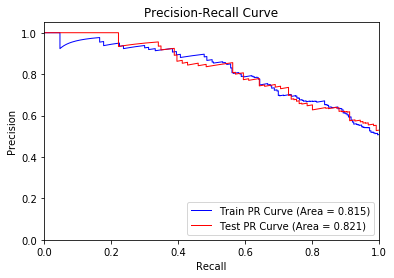

In [17]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 206


,HIF,Beta,Cluster
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.210884,8
118,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN STROMA_HE,0.188945,8
318,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.132045,8
178,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN STROMA_HE,0.130625,8
117,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN ESI_0080_HE,0.126706,8
...,...,...,...
81,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF MACROPHAGE IN ESI_0080_HE,-0.021513,11
259,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]]] IN [TUMOR]_HE,-0.022271,7
192,COUNT PROP [CANCER CELLS] IN [[ESI_0080] OVER [STROMA]]_HE,-0.022944,10
260,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]]] IN [EPITHELIAL]_HE,-0.024272,9


### Outer Loop 2

In [19]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(517, 607) (517,)
(259, 607) (259,)


In [18]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7709389567147614, 0.7796241213466519, 0.769607103218646, 0.7575049944506105, 0.7752852386237514, 0.7698024417314094, 0.7753947465778764, 0.7779533851276359, 0.7923107658157603, 0.7617891231964483, 0.7939400665926749, 0.7976011838697742, 0.7727813540510544, 0.7610521642619312, 0.7684602293747689, 0.7839659637439882, 0.768707362190159, 0.7475678875323715, 0.798234554199038, 0.7545364409914909, 0.7705068442471329, 0.7648153903070661, 0.7846481687014428, 0.7636833148353681, 0.7649071402145764, 0.7788353681095079, 0.7151801701812801, 0.7555160932297447, 0.7824062153163152, 0.7882441731409544]


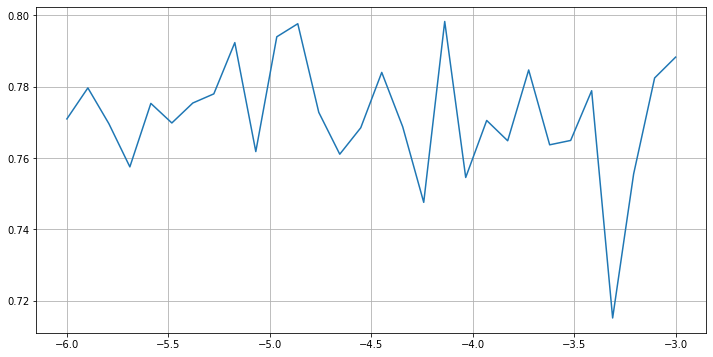

0.01595582943855103 -4.137931034482759


In [21]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.5
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

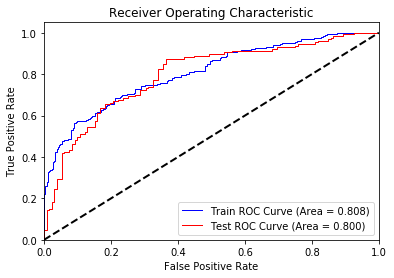

In [21]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

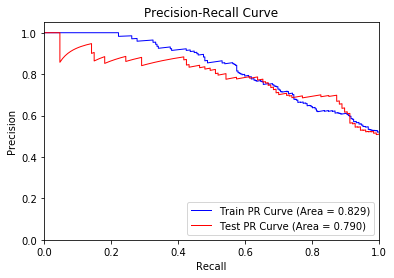

In [22]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 202


,HIF,Beta,Cluster
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.329871,8
287,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [TUMOR]_HE,0.196374,9
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.164986,8
285,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [ESI_008...,0.155641,9
59,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN TUMOR_HE,0.147312,8
...,...,...,...
259,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]]] IN [TUMOR]_HE,-0.050056,7
223,COUNT PROP [LYMPHOCYTE CELLS] IN [[TUMOR] OVER [STROMA]]_HE,-0.055059,14
213,COUNT PROP [LYMPHOCYTE CELLS] IN [[EPITHELIAL] OVER [STROMA]]_HE,-0.055059,14
261,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]]] IN [ESI_0080]_HE,-0.076321,8


### Outer Loop 3

In [24]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(518, 607) (518,)
(258, 607) (258,)


In [39]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7517158712541621, 0.7591949685534591, 0.7663988161302256, 0.7207961524232334, 0.782930077691454, 0.7875693673695894, 0.7755027746947836, 0.7625615982241953, 0.7689308176100629, 0.7594421013688494, 0.7872171661117278, 0.7307081021087681, 0.7981694413614502, 0.7786577876433591, 0.8021945985941545, 0.754962634110248, 0.7441627820939697, 0.7581176470588235, 0.7527058823529411, 0.7480073991860895, 0.7564247132815389, 0.7646170921198668, 0.7850270070292268, 0.7567946725860155, 0.7301191268960414, 0.7739519052904181, 0.7777906030336662, 0.7588250092489826, 0.7856455789863114, 0.7915072142064373]


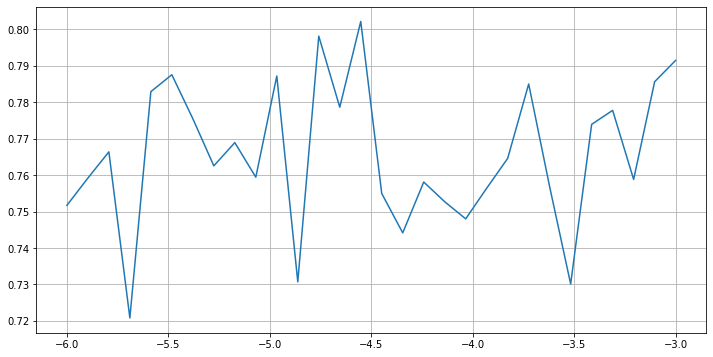

0.010549000763235271 -4.551724137931035


In [42]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

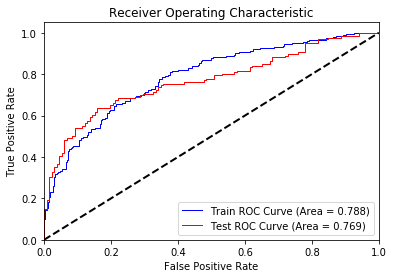

In [26]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

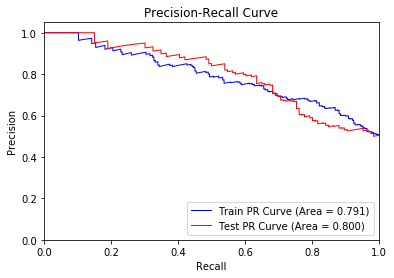

In [27]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 160


,HIF,Beta,Cluster
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.274929,8
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.168967,8
597,TOTAL [LYMPHOCYTE CELLS] IN [STROMA]_HE,0.164919,1
598,TOTAL [LYMPHOCYTE CELLS] IN [TUMOR]_HE,0.161111,1
122,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF MACROPHAGE IN STROMA_HE,0.140788,8
...,...,...,...
473,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF EPITHELIAL_HE,-0.009097,13
310,COUNT PROP [[[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,-0.009390,8
255,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]]] IN [TUMOR]_HE,-0.011022,9
252,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]]] IN [EPITHEL...,-0.012041,9


## Compute Ensemble Model

In [29]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.210884,0.329871,0.274929,8,0.271895
118,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN STROMA_HE,0.188945,0.101236,0.128200,8,0.139460
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.083832,0.164986,0.168967,8,0.139262
117,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN ESI_0080_HE,0.126706,0.117615,0.132679,8,0.125667
318,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.132045,0.116767,0.117809,8,0.122207
...,...,...,...,...,...,...
213,COUNT PROP [LYMPHOCYTE CELLS] IN [[EPITHELIAL] OVER [STROMA]]_HE,-0.000403,-0.055059,0.000000,14,-0.018487
259,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]]] IN [TUMOR]_HE,-0.022271,-0.050056,0.000000,7,-0.024109
260,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]]] IN [EPITHELIAL]_HE,-0.024272,-0.077833,0.000000,9,-0.034035
254,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]]] IN [STROMA]_HE,-0.013459,-0.018653,-0.076583,8,-0.036232


## Compute Final Train / Test Metrics

In [30]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.8063241106719368, 0.8082809224318658, 0.7875904243418599]
0.8007318191485542 0.009326645383523747


In [31]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.8102398854278553, 0.7999284180386542, 0.7688191438191437]
0.7929958157618845 0.017606157816699962


In [32]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.8154036625476778, 0.8286162879751607, 0.7906177878141467]
0.8115459127789951 0.015750834445196323


In [33]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.8212705528579278, 0.7902085628661447, 0.8000193518900813]
0.8038328225380513 0.012964534298091978


## Evaluate Hold-Out Set

In [37]:
holdout_df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/brca.tigit.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
# holdout_df

In [38]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,-0.343796,0.358039,-0.311635,0.496345,0.056839,-0.740434,1.087093,0.740434,0.574032,1.085272,...,-0.492480,-0.558243,-0.390196,-0.472494,-0.336232,-0.379379,-0.318799,-0.416680,-0.404132,-0.428783
1,-0.808067,-0.755442,0.601355,-0.032265,-0.500610,-1.180667,-1.336058,1.180667,-0.832628,-0.901205,...,2.161895,1.860668,0.695026,0.708207,1.787650,1.727157,-0.366536,0.093446,0.620873,0.386442
2,-1.319298,-1.440870,-0.211911,-1.378259,-1.518552,-1.673730,-2.820489,1.673730,-3.138150,-2.196502,...,-0.381173,-0.495269,-0.873592,-0.833646,-0.454034,-0.585149,-0.509478,-0.338779,0.202581,0.002108
3,0.653422,0.322065,-0.361029,-0.735734,0.001803,1.644597,1.161131,-1.644597,1.786537,1.449410,...,-0.694625,-0.535506,0.084567,-0.344055,-0.573230,-0.489229,-0.398271,-0.535527,-0.571302,-0.589488
4,-0.634182,-0.704660,0.689835,-0.174765,-0.471940,-0.665956,-1.186931,0.665956,-0.861668,-0.516511,...,1.448355,1.262737,0.252029,0.755657,2.206192,2.004251,-0.180924,0.557157,1.554704,1.202006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-1.021568,-1.204906,-0.362009,-1.438477,-1.372247,1.338994,0.357594,-1.338994,-2.698594,0.072184,...,-0.871119,-0.934287,-0.848041,-1.041901,-0.925324,-0.996618,-0.432673,-0.607811,-0.605218,-0.627904
197,-0.065050,0.542692,-0.343665,1.348842,0.674606,-0.885596,-0.021694,0.885596,-0.010115,-0.870291,...,0.045746,0.299523,3.432078,0.810430,-0.096526,0.635833,1.478380,0.445405,-0.218747,0.292902
198,-1.044750,-0.972275,-0.374685,-1.056441,-1.184024,-0.471468,0.980655,0.471468,0.084426,0.960077,...,-0.549604,-0.609385,-0.815239,-0.739623,-0.665273,-0.759720,-0.484677,-0.450383,-0.354619,-0.441419
199,0.469479,-0.438125,-0.148965,0.156552,0.363748,0.464192,-1.944139,-0.464192,-0.780493,-1.237130,...,0.101230,0.047964,1.399401,-0.477327,-0.096116,0.209055,0.551922,0.219684,0.496725,0.577930


In [39]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

99


In [40]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [41]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

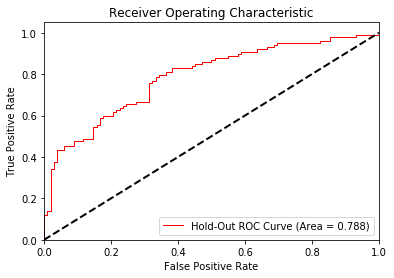

In [42]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.788


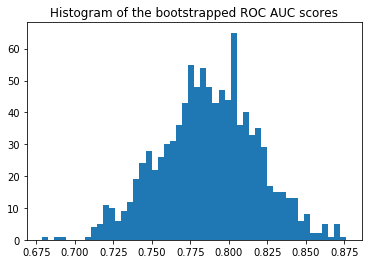

Confidence interval for the score: [0.723 - 0.848]


In [43]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

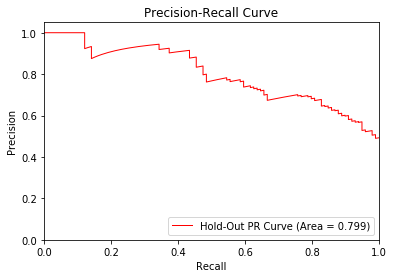

In [44]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.799


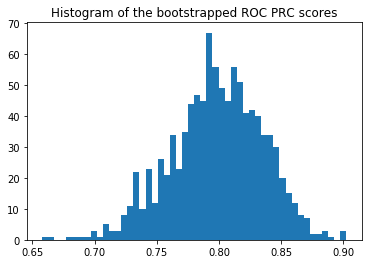

Confidence interval for the score: [0.724 - 0.865]


In [45]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))